# Data Collection

In [136]:
import pandas as pd
import numpy as np
from pprint import pprint
import requests
import json
import os
import math
import matplotlib

In [87]:
import json
from pandas.io.json import json_normalize
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Arc, Rectangle, ConnectionPatch
from matplotlib.offsetbox import  OffsetImage
from functools import reduce
import seaborn as sns

In [88]:
# add file names in dataset folder to file list
import os
file_list =[]
for filename in os.listdir('/Users/tomjones/Documents/Capstone/open-data-master/data/events'):
    if filename.endswith(".json"):
        file_list.append(filename)

In [89]:
# creates dictionary with game id as the key and game instances as values
# instance referes to an event within a game
games = {}
for file in file_list:
    with open('/Users/tomjones/Documents/Capstone/open-data-master/data/events/{}'.format(file), 'r') as fin:
        match = json.load(fin)
        games[file[:-5]] = match

In [90]:
# creates full list of instances with game id within each item dictionary
instance_list = []
for game_id_key,game in games.items(): 
    for game_instance in game:
        game_instance['game_id'] = game_id_key
        instance_list.append(game_instance)

In [91]:
# appends shot instance to shot list and their index to index list 
shots = []
index = []
c = 0

for event in instance_list:
    if event['type']['name'] == 'Shot':
        shots.append(event)
        index.append(c)
    c+=1

In [92]:
# appends first instances to list using instance index list created above
# does this also for second and third instances
first_instance =[]
second_instance =[]
third_instance =[]
for i in index:
    first_instance.append(instance_list[i-1])
    second_instance.append(instance_list[i-2])
    third_instance.append(instance_list[i-3])

In [93]:
# prints length of instance lists to ensure all the same length
print('number of shots is: ', len(shots))
print('number of index is: ', len(index))
print('number of first instances is: ',len(first_instance))
print('number of second instances is: ',len(second_instance))
print('number of third instances is: ',len(third_instance))

number of shots is:  22673
number of index is:  22673
number of first instances is:  22673
number of second instances is:  22673
number of third instances is:  22673


In [94]:
# creates dictionary for .JSON normalize
dictionary = {'shot': shots, '1st': first_instance, '2nd':second_instance, '3rd':third_instance}

In [95]:
# JSON normalises each dataframe for later concat
df_shot = pd.json_normalize(dictionary['shot'])
df_1st = pd.json_normalize(dictionary['1st'])
df_2nd = pd.json_normalize(dictionary['2nd'])
df_3rd = pd.json_normalize(dictionary['3rd'])

In [96]:
# JSON normalise creates headings with . for spaces so replace with_
# replaces . with _ in df_shot headings
list_shot_head = df_shot.columns
final_list_shot_head =[]
for head in list_shot_head:
    head = head.replace('.','_')
    final_list_shot_head.append(head)
df_shot.columns = final_list_shot_head

In [97]:
# adds _1st on the end of headings in df_1st so doesn't overwrite columns when concating all dataframes together 
list_1st_head = []
old_df_first_head = df_1st.columns
for head in old_df_first_head:
    list_1st_head.append(head + '_1st')
df_1st.columns = list_1st_head

In [98]:
# replaces . with _ in df_1st headings
final_list_1st_head =[]
for head in list_1st_head:
    head = head.replace('.','_')
    final_list_1st_head.append(head)
df_1st.columns = final_list_1st_head

In [99]:
# adds _2nd on the end of headings in df_2nd
list_2nd_head = []
old_df_second_head = df_2nd.columns
for head in old_df_second_head:
    list_2nd_head.append(head + '_2nd')
df_2nd.columns = list_2nd_head

In [100]:
# replaces . with _ in df_2nd headings
final_list_2nd_head =[]
for head in list_2nd_head:
    head = head.replace('.','_')
    final_list_2nd_head.append(head)
df_2nd.columns = final_list_2nd_head

In [101]:
# adds _3rd on the end of headings in df_3rd
list_3rd_head = []
old_df_third_head = df_3rd.columns
for head in old_df_third_head:
    head = head.replace('.','_')
    list_3rd_head.append(head + '_3rd')

In [102]:
# replaces . with _ in df_3rd headings
final_list_3rd_head =[]
for head in list_3rd_head:
    head = head.replace('.','_')
    final_list_3rd_head.append(head)
df_3rd.columns = final_list_3rd_head

In [103]:
# concats all dataframes into one
df = pd.concat([df_shot, df_1st, df_2nd, df_3rd], axis =1)

In [104]:
# number of null values in shot_freeze_frame
df.shot_freeze_frame.isnull().sum()

302

In [105]:
# shot_freeze_frame gives the player locations co-ordinates of teammates
# There are 302 missing values so must be dropped

In [106]:
# drops NaN values from shot_freeze_frame column
df = df[df['shot_freeze_frame'].notna()]

# Cleaning

In [107]:
# all columns headings with 'name' in the name require none values inplace of NaN values
# creates list of column headings which require None inplace of NaN values
name_heading_list = list(df[[col for col in df if 'name'in col]].columns)

In [108]:
# Replaces NaN values with none for name heading list
df[name_heading_list] = df[name_heading_list].fillna('None')

In [109]:
# column headings with id in can be dropped apart from game_id
# game_id allows stats from specific games to be easily extracted
# creates list of columns with id in the name
drop_id = list(df[[col for col in df if 'id'in col]].columns)
drop_id.remove('game_id')

In [110]:
# drops id column list from dataframe 
df.drop(columns = drop_id, inplace = True)

In [111]:
# all remaining columns with NaN values are Boolean dtypes so require False inplace of NaN
# creates list of column headings that require this
replace_with_false = [col for col in df.columns if col not in name_heading_list]

In [112]:
# replaces NaN values with False for replace_with_false columns list
df[replace_with_false] = df[replace_with_false].fillna(False)

In [113]:
# converts shot locations to from object dtype to float dtype
# coordinates come pre mainpulated so all shots are at the same end of the pitch
df['location'] = df['location'].apply(lambda x: [float(x[0]), float(x[1])])

# EDA

In [114]:
# pulls player location co-ordinates for opposition players in shot_freeze_frame
def pull_opposition_player_locations(cell):
    player_locations = []
    for i in range (len(cell)):
        if cell[i]['teammate'] == False:
            if cell[i]['position']['name'] != 'Goalkeeper': 
                try:
                    player_locations.append(cell[i]['location'])
                except:
                    player_locations.append(np.nan)
    return player_locations

In [115]:
# Applies pull_opposition_player_locations function to shot_freeze_frame and creates new column with opposition player locations at time of shot as a list
df['opposition_player_locations'] = df['shot_freeze_frame'].apply(pull_opposition_player_locations)

In [116]:
# pulls teammate player locations 
# if teammate goalkeeper is up for a corner assumes he's outfeild player
def pull_teammate_locations(cell):
    player_locations = []
    for i in range (len(cell)):
        if cell[i]['teammate'] == True:
                try:
                    player_locations.append(cell[i]['location'])
                except:
                    player_locations.append(np.nan)
    return player_locations

In [117]:
# applies pull_teammate_locationss to shot_freeze_frame and creates new column with teammate locations as a list
df['player_locations'] = df['shot_freeze_frame'].apply(pull_teammate_locations)

In [118]:
# pulls opponent goalkeeper position
def pull_goalkeeper_position(cell): 
    for i in range (len(cell)):
        if cell[i]['teammate'] == False:
            if cell[i]['position']['name'] == 'Goalkeeper':
                    try:
                        return cell[i]['location']
                    except:
                        return np.nan

In [119]:
# applies pull_goalkeeper_position to shot_freeze_frame and creates column with opposition goalkeeper co-ordinates 
df['goalkeeper_location'] = df['shot_freeze_frame'].apply(pull_goalkeeper_position)

In [120]:
# target variable is the outcome of the shot and needs converting to 1s & 0s for modeling
# if shot outcome is goal returns 1 else returns 0 
def target_variable (cell):
    if cell == 'Goal':
        cell = 1
    else:
        cell = 0
    return cell

In [121]:
# converts shot_outcome to 1s & 0s using target_variable function
df.shot_outcome_name = df.shot_outcome_name.apply(target_variable)
df['shot_outcome'] = df.shot_outcome_name

In [122]:
# draws football pitch on axis for base of diagrams
def draw_pitch(ax):
    # focus on only half of the pitch
    #Pitch Outline & Centre Line
    # Pitch = Rectangle([0,0], width = 120, height = 80, fill = False)
    #Left, Right Penalty Area and midline
    LeftPenalty = Rectangle([0,22.3], width = 14.6, height = 35.3, fill = False)
    RightPenalty = Rectangle([105.4,22.3], width = 14.6, height = 35.3, fill = False)
    midline = ConnectionPatch([60,0], [60,80], "data", "data")

    #Left, Right 6-yard Box
    LeftSixYard = Rectangle([0,32], width = 4.9, height = 16, fill = False)
    RightSixYard = Rectangle([115.1,32], width = 4.9, height = 16, fill = False)


    #Prepare Circles
    centreCircle = plt.Circle((60,40),8.1,color="black", fill = False)
    centreSpot = plt.Circle((60,40),0.71,color="black")
    #Penalty spots and Arcs around penalty boxes
    leftPenSpot = plt.Circle((9.7,40),0.71,color="black")
    rightPenSpot = plt.Circle((110.3,40),0.71,color="black")
    leftArc = Arc((9.7,40),height=16.2,width=16.2,angle=0,theta1=310,theta2=50,color="black")
    rightArc = Arc((110.3,40),height=16.2,width=16.2,angle=0,theta1=130,theta2=230,color="black")
    
  
    element = [LeftPenalty, RightPenalty, midline, LeftSixYard, RightSixYard, centreCircle, 
               centreSpot, rightPenSpot, leftPenSpot, leftArc, rightArc]
    for i in element:
        ax.add_patch(i)

In [123]:
# draws football pitch on axis for base of diagrams split into 2 sections
def split_pitch(ax):
    # focus on only half of the pitch
    #Pitch Outline & Centre Line
    # Pitch = Rectangle([0,0], width = 120, height = 80, fill = False)
    #Left, Right Penalty Area and midline
    LeftPenalty = Rectangle([0,22.3], width = 14.6, height = 35.3, fill = False)
    RightPenalty = Rectangle([105.4,22.3], width = 14.6, height = 35.3, fill = False)
    midline = ConnectionPatch([60,0], [60,80], "data", "data")

    #Left, Right 6-yard Box
    LeftSixYard = Rectangle([0,32], width = 4.9, height = 16, fill = False)
    RightSixYard = Rectangle([115.1,32], width = 4.9, height = 16, fill = False)


    #Prepare Circles
    centreCircle = plt.Circle((60,40),8.1,color="black", fill = False)
    centreSpot = plt.Circle((60,40),0.71,color="black")
    #Penalty spots and Arcs around penalty boxes
    leftPenSpot = plt.Circle((9.7,40),0.71,color="black")
    rightPenSpot = plt.Circle((110.3,40),0.71,color="black")
    leftArc = Arc((9.7,40),height=16.2,width=16.2,angle=0,theta1=310,theta2=50,color="black")
    rightArc = Arc((110.3,40),height=16.2,width=16.2,angle=0,theta1=130,theta2=230,color="black")
    
    # draws top section of pitch in red
    Topsection = Rectangle([0,40], width = 120, height = 40, fill = False, color ='red')
    # draws bottom section of pitch in blue
    Bottomsection = Rectangle([0,0], width = 120, height = 39.5, fill = False, color ='blue')
    
    element = [LeftPenalty, RightPenalty, midline, LeftSixYard, RightSixYard, centreCircle, 
               centreSpot, rightPenSpot, leftPenSpot, leftArc, rightArc,Topsection, Bottomsection]
    for i in element:
        ax.add_patch(i)

/Users/tomjones/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/tomjones/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


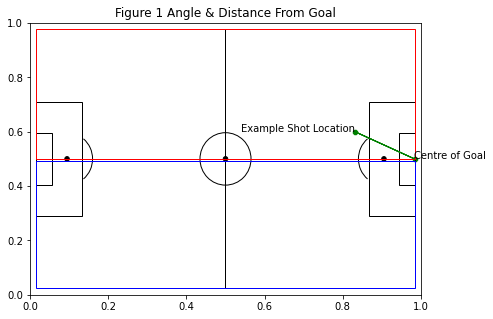

In [124]:
# plots figure 1 diagram for angle_of_shot and distance from goal

fig, ax = plt.subplots()
fig.set_size_inches(7, 5)

ax=fig.add_subplot(1,1,1)
split_pitch(ax) #overlay our different objects on the pitch
plt.ylim(-2, 82)
plt.xlim(-2, 122)
plt.axis('off')
plt.title('Figure 1 Angle & Distance From Goal')

# gives distance to cnetre of goal from a shot location
line_1 = plt.arrow(101.1, 48.4, 120.0-101.1, 40 - 48.4  ,color = 'green', lw=1)
plt.gca().add_line(line_1)

# shot location
sns.scatterplot([101.1], [48.4], color = "green")
plt.text(101.1,48.4,'Example Shot Location',horizontalalignment='right')

# centre of goal
sns.scatterplot([120], [40], color = "green")
plt.text(120, 40,'Centre of Goal')

plt.show()

In [125]:
# determines the angel of the shot from the shot location to the centre of the goal
# Given as the angle of the green line in figure 1 above
def angle_from_goal(cell):
    try:
        if cell[0] != 120:
            if cell[1] < 40: 
                # quandrant 1 (0-120,0-40) seen in blue above
                o = 40 - cell[1]
                a = 120 - cell[0]
                x = math.degrees(math.atan(o/a))
                return x
            elif cell[1] > 40: 
                # quandrant 2 (0-120,40-80) seen in red above
                o = 80 - cell[1]
                a = 120 - cell[0]
                x = math.degrees(math.atan(o/a))
                return x
            else:
                return 0
        else:
            return 0 
    except:
        return np.nan

In [126]:
# creates column angle_of_shot using angle_from_goal by applying it to shot location
# all shots are at the same goal for comparison
df['angle_of_shot'] = df.location.apply(angle_from_goal)

In [127]:
# calculates distance from shot location to centre of goal using pythagoras theorem
# Given as the length of the green line in figure 1 above

from math import sqrt

def distance_to_goal(cell):
    if cell[1] < 40: # for top segment of pitch
        a = (120 - cell[0])**2
        b = (40 - cell[1])**2
        return sqrt(a+b)
    else:
        a = (120 - cell[0])**2
        b = (80 - cell[1])**2
        return sqrt(a+b)

In [128]:
# creates column distance_to_goal using distance_to_goal function 
df['distance_from_goal'] = df.location.apply(distance_to_goal)

/Users/tomjones/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/tomjones/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/tomjones/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpreta

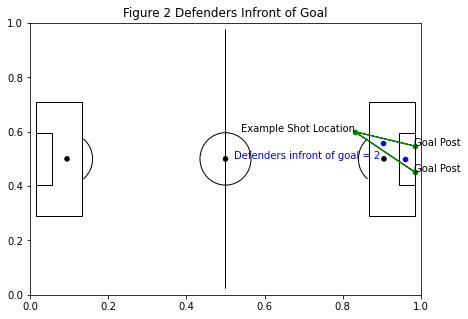

In [129]:
# plots figure 2 diagram for defenders infront of goal

fig, ax = plt.subplots()
fig.set_size_inches(7, 5)

ax=fig.add_subplot(1,1,1)
draw_pitch(ax) #overlay our different objects on the pitch
plt.ylim(-2, 82)
plt.xlim(-2, 122)
plt.axis('off')
plt.title('Figure 2 Defenders Infront of Goal')

# line from shot location to post
line_1 = plt.arrow(101.1, 48.4, 120.0-101.1, 44 - 48.4  ,color = 'green', lw=1)
plt.gca().add_line(line_1)

# line from shot location to other post
line_2 = plt.arrow(101.1, 48.4, 120.0-101.1, 36 - 48.4  ,color = 'green', lw=1)
plt.gca().add_line(line_2)

# shot location
sns.scatterplot([101.1], [48.4], color = "green")
plt.text(101.1,48.4,'Example Shot Location', horizontalalignment='right')

# Goal Post
sns.scatterplot([120], [44], color = "green")
plt.text(120, 44,'Goal Post')

# Goal Post
sns.scatterplot([120], [36], color = "green")
plt.text(120, 36,'Goal Post')

# Defender 1
sns.scatterplot([117], [40], color = "blue")

# Defender 2
sns.scatterplot([110], [45], color = "blue")

# defenders infront of goal label
plt.text(109, 40,'Defenders infront of goal = 2', color ='blue', horizontalalignment='right')

plt.show()

In [130]:
# goal posts (120, 36) to (120,44)
# creates triangle between shot location and 2 posts as seen in figure 2 above
# uses shapely to determine number of opposition players in triangle not including opposition goalkeeper

# i = shot location 
# j = opposition players 

from shapely.geometry import Point
from shapely.geometry.polygon import Polygon

def defenders_infront_of_goal(i, j):
    triangle = Polygon([(i), (120, 36), (120, 44)])
    defender_list = []
    for player in j:
        point = Point(player)
        if triangle.contains(point) == True:
            defender_list.append(1)
        else:
            defender_list.append(0)
    return sum(defender_list)

In [131]:
# creates ;ist of values for how many defenders in front of goal for concat with main dataframe
players_infront_of_goal_list = []
for i in range(len(df)):
    players_infront_of_goal_list.append(defenders_infront_of_goal(df.location.iloc[i], df.opposition_player_locations.iloc[i]))

In [132]:
# added players_infront_of_goal_list to main dataframe 
df['defenders_infront_of_goal']= players_infront_of_goal_list

In [133]:
# converts shot end location from 3D arrary in the x,y,z plane to 2D array in y,z plane
# y,z plane gives face of goal
def goal_location(cell):
    if len(cell) == 3:
        return [cell[1], cell[2]]
    elif len(cell) ==2:
        return [cell[-1], 0] # missing dimensions in array are given as zero so need to be added to array
    else:
        return np.nan

In [134]:
# converts shot_end_location from 3D array to 2D array in yz plane for face of goal
df['shot_end_location'] = df['shot_end_location'].apply(goal_location)

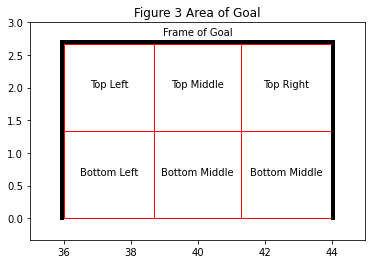

In [137]:
# Plots figure 3 area of goal diagram 

fig = plt.figure() 
ax = fig.add_subplot(111) 
  
# Top left 
TL = matplotlib.patches.Rectangle((36, 1.335), 2.7, 2.67-1.335, fill = False, color ='red') 
plt.text(37.35, 2,'Top Left', horizontalalignment='center')

# Bottom left
BL = matplotlib.patches.Rectangle((36,0), 2.7, 1.335, fill = False, color ='red')
plt.text(37.35, 0.667,'Bottom Left', horizontalalignment='center')

# Top middle
TM = matplotlib.patches.Rectangle((38.7,1.335), 2.6, 2.67-1.335, fill = False, color ='red')
plt.text(40, 2,'Top Middle', horizontalalignment='center')

# Bottum middle
BM = matplotlib.patches.Rectangle((38.7,0), 2.6, 2.67-1.335, fill = False, color ='red')
plt.text(40, 0.667,'Bottom Middle', horizontalalignment='center')

# Top right
TR = matplotlib.patches.Rectangle((41.3,1.335), 2.7, 2.67-1.335, fill = False, color ='red')
plt.text(42.65, 2,'Top Right', horizontalalignment='center')

# Bottum right
BR = matplotlib.patches.Rectangle((41.3,0), 2.7, 1.335, fill = False, color ='red')
plt.text(42.65, 0.667,'Bottom Middle', horizontalalignment='center')

# Goal Frame
plt.text(40, 2.8,'Frame of Goal', horizontalalignment='center')
plt.plot([35.95,44], [2.7,2.7], lw=4, color ='black')
plt.plot([35.95,35.95], [0,2.7], lw=4, color ='black')
plt.plot([44.05,44.05], [0,2.7], lw=4, color ='black')

ax.add_patch(TL) 
ax.add_patch(BL) 
ax.add_patch(TM)
ax.add_patch(BM)
ax.add_patch(TR)
ax.add_patch(BR)
plt.title('Figure 3 Area of Goal')
  
plt.xlim([35, 45]) 
plt.ylim([-0.33, 3]) 
  
plt.show() 

In [138]:
# goal split into 6 equal segments 
# Top left of goal - TL = (36, 2.67), (38.7, 2.67), (38.7,1.335) , (36,1.335)
# Bottom left of goal - BL = (38.7,1.335) , (36,1.335), (38.7,0), (36,0)
# Top middle of goal - TM = (38.7, 2.67), (41.3, 2.67), (38.7,1.335) , (41.3,1.335)
# Bottum middle - BM = (38.7,1.335), (41.3,1.335), (38.7,0), (41.3,0)
# Top rright - TR = (41.3,1.335), (41.3, 2.67), (44, 2.67), (44,1.335)
# Bottum right - BR = (44, 1.335), (44, 0), (41.3,1.335), (41.3,0) 
# uses shapley to determine which area of goal the shot ends in and replaces it with label
# see figure 3 above

def area_of_goal(cell):
    top_left = Polygon([(36, 2.67), (38.7, 2.67), (38.7,1.335), (36,1.335)])
    bottom_left = Polygon([(38.7,1.335) , (36,1.335), (38.7,0), (36,0)])
    top_mid = Polygon([(38.7, 2.67), (41.3, 2.67), (38.7,1.335), (41.3,1.335)])
    bottom_mid = Polygon([(38.7,1.335), (41.3,1.335), (38.7,0), (41.3,0)])
    top_right = Polygon([(41.3,1.335), (41.3, 2.67), (44, 2.67), (44,1.335)])
    bottom_right = Polygon([(44, 1.335), (44, 0), (41.3,1.335), (41.3,0)])
    point = Point(cell)
    if top_left.contains(point) == True:
        return 'TL'
    elif bottom_left.contains(point) == True:
        return 'BL'
    elif top_mid.contains(point) == True:
        return 'TM'
    elif bottom_mid.contains(point) == True:
        return 'BM'
    elif top_right.contains(point) == True:
        return 'TR'
    elif bottom_right.contains(point) == True:
        return 'BR'
    else:
        return 'OFF_TARGET'

In [139]:
# converts shot_end_location to an area of the goal using area_of_goal function above
df['area_of_goal'] = df['shot_end_location'].apply(area_of_goal)

In [140]:
# saves dataframe to csv
df.to_csv('visualisation.csv')

# Columns to Drop

In [67]:
df.drop(columns = ['timestamp',
'location',
'related_events',
'shot_end_location',
'shot_freeze_frame',
'timestamp_1st',
'duration_1st',
'related_events_1st',
'possession_team_name_1st',
'player_name_1st',
'carry_end_location_1st',
'pass_length_1st',
'pass_angle_1st',
'pass_end_location_1st',
'tactics_lineup_1st',
'location_1st',
'goalkeeper_end_location_1st',
'substitution_replacement_name_1st',
'shot_statsbomb_xg_1st',
'shot_end_location_1st',
'shot_freeze_frame_1st',
'timestamp_2nd',
'location_2nd',
'related_events_2nd',
'possession_team_name_2nd',
'team_name_2nd',
'player_name_2nd',
'duration_2nd',
'pass_recipient_name_2nd',
'pass_length_2nd',
'pass_angle_2nd',
'pass_end_location_2nd',
'carry_end_location_2nd',
'goalkeeper_end_location_2nd',
'shot_statsbomb_xg_2nd',
'shot_end_location_2nd',
'shot_freeze_frame_2nd',
'tactics_lineup_2nd',
'timestamp_3rd',
'tactics_lineup_2nd',
'location_3rd',
'duration_3rd',
'related_events_3rd',
'possession_team_name_3rd',
'team_name_3rd',
'player_name_3rd',
'pass_recipient_name_3rd',
'pass_length_3rd',
'pass_angle_3rd',
'pass_end_location_3rd',
'carry_end_location_3rd',
'shot_statsbomb_xg_3rd',
'shot_end_location_3rd',
'shot_freeze_frame_3rd',
'goalkeeper_end_location_3rd',
'substitution_replacement_name_3rd',
'tactics_lineup_3rd', 
'opposition_player_locations',
'player_locations', 
'goalkeeper_location',
'shot_end_location',
'shot_outcome_name',
'pass_goal_assist_3rd',
'pass_goal_assist_2nd',
'shot_redirect_3rd',
'shot_statsbomb_xg'],  axis = 1, inplace = True)

In [68]:
# These are catergorical variables so require None inplace of false
df[['tactics_formation_1st','tactics_formation_2nd','tactics_formation_3rd']] = df[['tactics_formation_1st','tactics_formation_2nd','tactics_formation_3rd']].replace(to_replace=False, value='None', inplace = True)

/Users/tomjones/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4379: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(


# Dummy variables

In [69]:
# Gives the list of headings with name in that were dropped above
name_headings_dropped_list = ['player_name_2nd', 
 'player_name_3rd', 
 'team_name_2nd', 
 'substitution_replacement_name_1st', 
 'player_name_1st', 
 'team_name_3rd', 
 'pass_recipient_name_2nd', 
 'substitution_replacement_name_3rd', 
 'possession_team_name_1st', 
 'possession_team_name_3rd', 
 'possession_team_name_2nd', 
 'pass_recipient_name_3rd',
 'shot_outcome_name'] 

In [70]:
# creates list of columns with name in the heading that require dummying and haven't already been dropped
columns_to_dummy = [col for col in name_heading_list if col not in name_headings_dropped_list]

In [71]:
# dummies variables in columns_to_dummy list
df = pd.get_dummies(df, columns= columns_to_dummy , drop_first=True)

In [72]:
# dummies variables without name in the heading
df = pd.get_dummies(df, columns= ['area_of_goal','tactics_formation_1st','tactics_formation_2nd','tactics_formation_3rd'] , drop_first=True)

In [73]:
# creates list of columns with boolean data type
boolean_list = list(df.select_dtypes(include=['bool']).columns)

In [74]:
# converts boolean data type to integers 
df[boolean_list] = df[boolean_list].astype(int)

In [75]:
# saves dataframe to csv
df.to_csv('modelling.csv')

In [76]:
dfc = pd.read_csv('modelling.csv')

In [77]:
df_corr = dfc.corr()

In [78]:
df_c = df_corr.shot_outcome

In [79]:
df_c.sort_values()

area_of_goal_OFF_TARGET     -0.367165
pass_shot_assist_3rd        -0.215268
pass_shot_assist_2nd        -0.174678
defenders_infront_of_goal   -0.105032
distance_from_goal          -0.091327
                               ...   
area_of_goal_TL              0.156332
area_of_goal_TR              0.165486
area_of_goal_BR              0.170194
shot_open_goal               0.224235
shot_outcome                 1.000000
Name: shot_outcome, Length: 3406, dtype: float64

In [13]:
df.shot_redirect_3rd.value_counts()

0    22371
Name: shot_redirect_3rd, dtype: int64

In [ ]:
df_corr[df_corr['shot_outcome'] > 0.8]

In [90]:
df_corr = df.corr() 

,index,period,minute,second,possession,duration,shot_statsbomb_xg,shot_first_time,shot_deflected,under_pressure,...,50_50_outcome_name_3rd_Success To Opposition,50_50_outcome_name_3rd_Success To Team,50_50_outcome_name_3rd_Won,bad_behaviour_card_name_3rd_Yellow Card,area_of_goal_BM,area_of_goal_BR,area_of_goal_OFF_TARGET,area_of_goal_TL,area_of_goal_TM,area_of_goal_TR
index,1.000000,0.839140,0.970608,-0.004919,0.931074,-0.026670,0.036546,-0.024359,0.001945,-0.017150,...,0.001927,-0.011194,-0.003963,0.011900,-0.000231,-0.007732,-0.001924,-0.000354,0.008668,-0.000989
period,0.839140,1.000000,0.854692,-0.009219,0.840484,-0.006376,0.026128,-0.032172,0.004659,-0.009060,...,-0.006968,-0.006968,-0.009854,0.005761,0.001826,-0.010245,0.000169,-0.003798,0.009348,-0.002407
minute,0.970608,0.854692,1.000000,-0.013206,0.969878,-0.007216,0.028311,-0.035454,-0.000298,-0.017806,...,-0.001061,-0.011018,-0.002733,0.010647,-0.004293,-0.009438,0.000342,0.002072,0.010222,0.001221
second,-0.004919,-0.009219,-0.013206,1.000000,-0.004568,0.005294,0.004585,0.007420,0.007440,-0.000581,...,-0.004050,-0.006755,-0.001083,0.007686,0.010246,0.004812,0.000634,-0.009379,0.009969,-0.002908
possession,0.931074,0.840484,0.969878,-0.004568,1.000000,0.002539,0.025212,-0.038820,0.000839,-0.015784,...,-0.000947,-0.010347,-0.001176,0.008723,-0.004275,-0.010765,0.000660,0.002734,0.010460,0.001771
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
area_of_goal_BR,-0.007732,-0.010245,-0.009438,0.004812,-0.010765,0.014370,0.079297,0.027563,0.040833,-0.004815,...,-0.001297,-0.001297,-0.001834,0.010090,-0.035848,1.000000,-0.387420,-0.037568,-0.021517,-0.037254
area_of_goal_OFF_TARGET,-0.001924,0.000169,0.000342,0.000634,0.000660,-0.040804,-0.159766,-0.008783,-0.100237,0.012485,...,0.003347,0.003347,0.004734,-0.010085,-0.369207,-0.387420,1.000000,-0.386925,-0.221613,-0.383688
area_of_goal_TL,-0.000354,-0.003798,0.002072,-0.009379,0.002734,0.023266,0.018615,-0.028599,0.047962,-0.009029,...,-0.001295,-0.001295,-0.001832,0.023648,-0.035802,-0.037568,-0.386925,1.000000,-0.021490,-0.037206
area_of_goal_TM,0.008668,0.009348,0.010222,0.009969,0.010460,0.026088,0.003176,-0.006435,0.024475,0.006288,...,-0.000742,-0.000742,-0.001049,-0.001963,-0.020506,-0.021517,-0.221613,-0.021490,1.000000,-0.021310
